In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [59]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = str(session.query(Measurement.date).order_by(Measurement.date.desc()).first())

last_date_dt = dt.datetime.strptime(last_date, "('%Y-%m-%d',)")

year_ago = last_date_dt - dt.timedelta(days=365)


In [13]:
# Perform a query to retrieve the data and precipitation scores
precip_results = session.query(Measurement.date, Measurement.prcp).\
    filter(func.DATE(Measurement.date) > year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
p_df = pd.DataFrame(precip_results, columns=['date', 'prcp'])
precip_df = pd.DataFrame(precip_results, columns=['date', 'prcp'])
precip_df.set_index('date', inplace=True)


# Sort the dataframe by date
precip_df.sort_values(by=['date'], inplace=True)
precip_df.head(10)

,prcp
date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15
2016-08-24,1.45
2016-08-24,1.22
2016-08-25,0.08
2016-08-25,0.00


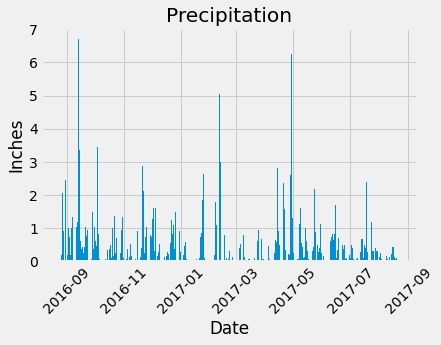

In [14]:
# plot the precitipation data
dates = precip_df.index
x_values = [dt.datetime.strptime(d,"%Y-%m-%d").date() for d in dates]
y_values = precip_df["prcp"]

plt.figure()
plt.bar(x_values, y_values)
plt.title("Precipitation")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=45)
plt.show()

In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe().round(decimals=2)

,prcp
count,2015.00
mean,0.18
std,0.46
min,0.00
25%,0.00
50%,0.02
75%,0.13
max,6.70


In [47]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).distinct().count()
print(f"There are {station_count} stations.")

There are 9 stations.


In [73]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(desc(func.count(Measurement.station))).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [83]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_station = station_activity[0][0]

low_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
high_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_station).all()

print(f"Temperature readings for station {active_station}:")
print(f"Lowest temperature: {low_temp[0][0]}")
print(f"Highest temperature: {high_temp[0][0]}")
print(f"Average temperature: {avg_temp[0][0]}")

Temperature readings for station USC00519281:
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [27]:
# Plot the daily normals as an area plot with `stacked=False`
